In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import copy
from scipy import signal

if not os.path.exists("plytkaSzumImp.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/06_Context/plytkaSzumImp.png --no-check-certificate

## Zadanie domowe: adaptacyjna filtracja medianowa

Wszystkie omówione i przetestowane powyżej filtry działały w ten sam sposób dla każdego piksela obrazu.
Natomiast przy filtracji adaptacyjnej następuje zmiana parametrów filtru w zależności od statystycznych charakterystyk otoczenia rozpatrywanego piksela.

Omówiony poprzednio filtr medianowy dobrze eliminuje zakłócenia impulsowe o niewielkiej gęstości przestrzennej (mniej niż 20% w pionie i poziomie). 
W zadaniu filtracji bardziej zakłóconych obrazów lepiej sprawdza się adaptacyjny filtr medianowy.  
``Adaptacyjność'' filtra polega na zmianie rozmiaru okna w trakcie filtracji - w zależności od pewnych warunków.

Przyjmijmy następujące oznaczenia:
- $z_{min}$ - najmniejsza jasność w oknie $S_{xy}$
- $z_{max}$ - największa jasność w oknie $S_{xy}$
- $z_{med}$ - mediana z jasności w oknie $S_{xy}$
- $z_{xy}$  - jasność w punkcie o współrzędnych $(x,y)$
- $S_{max}$ - maksymalny dozwolony rozmiar okna $S_{xy}$


Algorytm można opisać następującym pseudokodem:
<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
Faza A :<br>	
&nbsp;&nbsp;&nbsp;<b>if</b>  $z_{max}$ > $z_{med}$ > $z_{min}$ <b>then</b> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; to przejdź od fazy B<br>
&nbsp;&nbsp;&nbsp;<b>else</b><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;zwiększ rozmiar okna<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>if</b> rozmiar okna <= $S_{max}$ <b>then</b><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;to powtórz fazę A<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>else</b><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;zwróć $z_{med}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>end if</b><br>
&nbsp;&nbsp;&nbsp;<b>end if</b><br>
Faza B :<br>
&nbsp;&nbsp;&nbsp;<b>if</b>  $z_{max}$ > $z_{xy}$ > $z_{min}$ <b>then</b>  <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;to zwróć  $z_{xy}$ <br>
&nbsp;&nbsp;&nbsp;<b>else</b><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;zwróć $z_{med}$<br>
&nbsp;&nbsp;&nbsp;<b>end if</b><br>
</div>


#### Wyjaśnienie działania:

Cały czas należy pamiętać, jakie są cele działania filtru:
- usunięcie zakłóceń typu pieprz i sól (ang. _salt and pepper noise),
- wygładzenie innego rodzaju zakłóceń,
- redukcja zniekształceń (pogrubianie albo pocienianie krawędzi).

Wartości $z_{min}$ i $z_{max}$ uważa się za zakłócenia impulsowe w danym oknie, nawet jeżeli nie są to największa i najmniejsza wartość w całym obrazie.

Celem fazy A jest określenie czy rezultat filtracji medianowej $z_{med}$ jest zakłóceniem impulsowym czy nie. 
Jeżeli spełniona jest nierówność $z_{min}$ < $z_{med}$ < $z_{max}$ wartość  $z_{med}$ nie może być zakłóceniem impulsowym. 
W takim przypadku przechodzimy do fazy B i sprawdzamy czy piksel $z_{xy}$ jest zakłóceniem impulsowym. 
Jeżeli spełniona jest nierówność   $z_{min}$ < $z_{xy}$ < $z_{max}$, $z_{xy}$ nie może być zakłóceniem impulsowym. 
W takim przypadku algorytm zwraca niezmienioną wartość $z_{xy}$ - w ten sposób zmniejsza się zniekształcenia.
Jeżeli nierówność  $z_{min}$ < $z_{xy}$ < $z_{max}$ nie jest spełniona oznacza to, że albo $z_{xy}$ = $z_{min}$ albo  $z_{xy}$ = $z_{max}$. 
W obu przypadkach uznaje się, że wartość  $z_{xy}$ jest zakłóceniem i jako wynik filtracji zwraca się wartość  $z_{med}$ , o której na podstawie fazy A wiadomo, że nie jest zakłóceniem.

Przypuśćmy, że nie została spełniona nierówność   $z_{min}$ < $z_{med}$ < $z_{max}$, algorytm wtedy zwiększa rozmiar okna i powtórnie wykonuje fazę A. 
Dzieje się tak aż do momentu, kiedy algorytm znajdzie medianę, która nie jest zakłóceniem impulsowym albo osiągnięty zostanie maksymalny rozmiar okna. 
W przypadku gdy osiągnięty zostanie maksymalny rozmiar okna algorytm zwraca wartość $z_{med}$. 
Nie ma gwarancji, że wartość ta nie jest zakłóceniem impulsowym, jednakże odpowiedni dobór maksymalnego rozmiaru okna pozwala zminimalizować prawdopodobieństwo wystąpienia takiej sytuacji.

Po wyznaczeniu wartości po filtracji dla danego piksela, okno filtru się przemiesza, a algorytm uruchamiany jest dla nowej lokalizacji z parametrami początkowymi.

#### Zadanie - zaimplementować metodę:

1. Wczytaj obrazy _plytkaSzumImp.png_.  Wyświetl go.

2. Przefiltruj obraz filtrem medianowym o rozmiarze okna $5 \times 5$. Wynik filtracji wyświetl.

3. Zaimplementuj opisany adaptacyjny filtr medianowy. Wskazówki:
- należy przyjąć maksymalny rozmiar okna na $7 \times 7$, a początkowy na $3 \times 3$. Zakładamy, że rozmiar filtru powinien być nieparzysty. 
- obliczenia trzeba wykonać w dwóch pętlch `for` (odwiedzić, każdy piksel) - dla ułatwienia zaleca się pominięcie pikseli brzegowych (jeżeli maksymalny rozmiar okna wynosi $7 \times 7$ to nie należy dokonywać obliczeń dla 3 pikseli brzegowych)
- w każdej iteracji należy:
    - przywrócić początkowy rozmiar okna ($3 \times 3$),
    - "wyciąć" otoczenie (parametr opisujący rozmiar otoczenia należy "uzmiennić")
    - obliczyć parametry: $z_{min}$, $z_{max}$, $z_{med}$ (metody wycinka `min`, `max` i funkcja `np.median` 

- wykonać opisany algorytm. Uwaga: obliczenia mogę się chwilkę wykonywać.

4. Porównaj rezultaty filtracji medianowej i adaptacyjnej.      

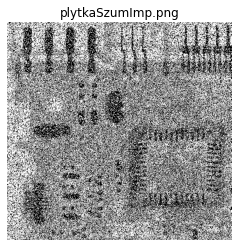

In [2]:
I = cv2.imread('plytkaSzumImp.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(I, 'gray'), plt.axis('off'), plt.title('plytkaSzumImp.png')
plt.show()

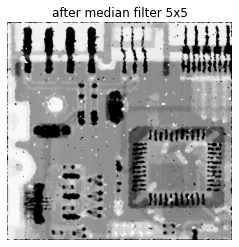

In [3]:
I1 = signal.medfilt2d(I, kernel_size=5)
plt.imshow(I1, 'gray'), plt.axis('off'), plt.title('after median filter 5x5')
plt.show()

In [4]:
def adaptive_median(I, y, x, S_xy, S_max):
    mask = I[y-S_xy//2:y+S_xy//2+1, x-S_xy//2:x+S_xy//2+1]
    z_min = np.min(mask)
    z_max = np.max(mask)
    z_med = np.median(mask)
    z_xy = I[y, x]

    if z_max > z_med > z_min:
        if z_max > z_xy > z_min:
            return z_xy
        else:
            return z_med
    else:
        if S_xy+2 <= S_max:
            return adaptive_median(I, y, x, S_xy+2, S_max)
        else:
            return z_med

def adaptive_median_filter(img, S_max=7):
    (Y, X) = img.shape
    I_copy = copy.deepcopy(img)
    S_max = 7

    for y in range(S_max//2, Y-S_max//2+1):
        for x in range(S_max//2, X-S_max//2+1):
            I_copy[y, x] = adaptive_median(img, y, x, 3, S_max)
            
    return I_copy

In [5]:
I2 = adaptive_median_filter(I, S_max=7)

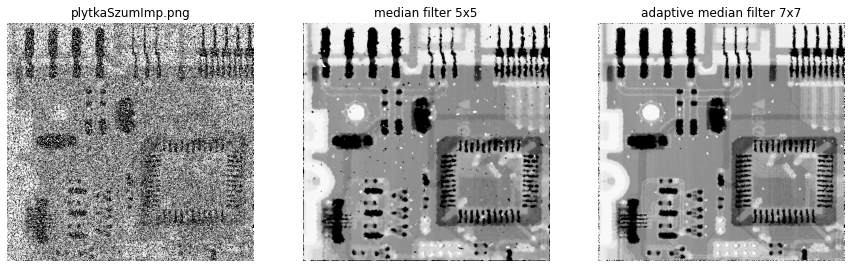

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(I, 'gray', vmin=0, vmax=256), ax[0].set_title('plytkaSzumImp.png')
ax[1].imshow(I1, 'gray', vmin=0, vmax=256), ax[1].set_title('median filter 5x5')
ax[2].imshow(I2, 'gray', vmin=0, vmax=256), ax[2].set_title('adaptive median filter 7x7')
for i in range(3):
    ax[i].axis('off')
plt.show()